In [2]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt 
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
from sklearn.metrics import r2_score
from xgboost import XGBRegressor 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")


In [37]:
def logit_pvalue(model, dataset, columns):
    p = model.predict_proba(dataset[columns])
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(dataset[columns]), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    cols = columns[:]
    cols.insert(0, "intercept")
    p *= 100
    result = pd.DataFrame({"variable" : cols, "p_value" : p})
    return result
def print_log_reg_coefs(dataset, model, columns):
    fig, ax = plt.subplots(figsize = (20, 6))
    x = columns
    x_pos = np.arange(len(x))
    y = model.coef_[0]

    ax.bar(x_pos, y)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x, rotation = 45)
    plt.show()
    #print(logit_pvalue(model, dataset, columns))
def print_lin_reg_coefs(dataset, model, columns):
    fig, ax = plt.subplots(figsize = (20, 6))
    x = columns
    x_pos = np.arange(len(x))
    y = model.coef_
    ax.bar(x_pos, y)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x, rotation = 45)
    plt.show()
def metrics_class(dataset, dataset_name, target, prediction, n_buckets = 5):
    
    auc = roc_auc_score(dataset[target], dataset[prediction])
    print(f"AUC ROC {dataset_name}: {auc:.4f}")
    dataset["q"] = pd.qcut(dataset[prediction], n_buckets, labels = list(range(n_buckets)))
    dataset.groupby("q")[[target, prediction]].mean().plot(title = f"PKP for {dataset_name}")
    plt.show()
def metrics_reg(dataset, dataset_name, target, prediction):
    x = dataset[target]
    y = dataset[prediction]
    z = np.polyfit(x,y,1)
    a,b = z
    x1 = dataset["result"].min()
    y1 = (a * x1) + b
    x2 = dataset["result"].max()
    y2 = (a * x2) + b
    print(f"R2 for {dataset_name}: {r2_score(x, y):.4f}")
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_title(dataset_name)
    ax.scatter(x, y, alpha=.5, label = "prediction")
    ax.plot([x1, x2], [y1, y2], color = "red", label = "trend")
    ax.plot([x1, x2], [x1, x2], color = "green", label = "perfect")
    ax.legend()
    plt.show()


In [4]:
df = pd.read_excel("seuk_04.xlsx")
df = df.dropna(axis = 1, how = "all")
names = list(df["Attack_1"].unique())

<Axes: xlabel='month'>

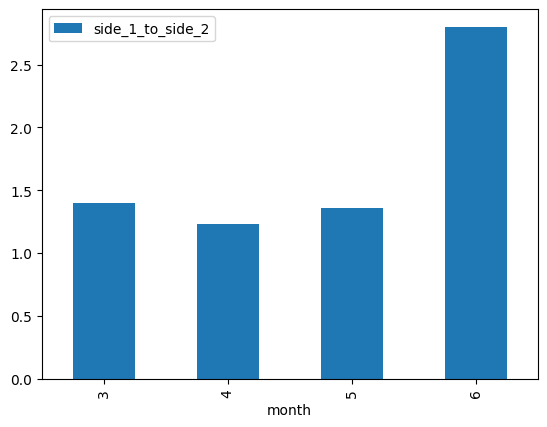

In [5]:
df["month"] = df["Date"].dt.month

df_side = pd.DataFrame(df.groupby(["month", "Win"])["Date"].count()).reset_index().rename(
    columns = {"Win" : "side", "Date" : "wins"}).sort_values("month")

df_uplift = pd.DataFrame(columns = ["month"])

df_uplift["month"] = df_side["month"].unique()

df_uplift = df_uplift.sort_values("month")

df_uplift["side_1_to_side_2"] = df_side[df_side["side"] == 1]["wins"].values / df_side[df_side["side"] == 2]["wins"].values

df_uplift.plot(kind = "bar", x = "month", y = "side_1_to_side_2")

In [6]:
df_dumm = pd.get_dummies(df, columns = ["Attack_1","Defence_1", "Attack_2", "Defence_2"])

In [7]:
df_bad = pd.DataFrame(columns = ["name", "index"])
k = 0
for name in names:
    cols = [i for i in df_dumm.columns if name in i]
    s = df_dumm[cols].sum(axis = 1)
    for index in s.where(s > 1).dropna().index:
        df_bad.loc[k] = name, index
        k += 1

In [8]:
df_dumm = df_dumm.drop(index = df_bad["index"].values)

In [9]:
dumm_columns = list(set(df_dumm.columns) - set(df.columns))
dumm_columns = sorted(dumm_columns, key=lambda x: x[x.rfind("_") + 1:] + x[:x.rfind("_")])

In [10]:
df_dumm = df_dumm.sort_values("Date")

In [11]:
df_dumm[dumm_columns].mean()

Attack_1_Dawid       0.099010
Attack_2_Dawid       0.222772
Defence_1_Dawid      0.158416
Defence_2_Dawid      0.168317
Attack_1_Eryk        0.094059
Attack_2_Eryk        0.089109
Defence_1_Eryk       0.089109
Defence_2_Eryk       0.094059
Attack_1_Krzysiu     0.222772
Attack_2_Krzysiu     0.232673
Defence_1_Krzysiu    0.173267
Defence_2_Krzysiu    0.202970
Attack_1_Kuba        0.123762
Attack_2_Kuba        0.138614
Defence_1_Kuba       0.198020
Defence_2_Kuba       0.173267
Attack_1_Szymon      0.306931
Attack_2_Szymon      0.118812
Defence_1_Szymon     0.202970
Defence_2_Szymon     0.143564
Attack_1_Wojtek      0.153465
Attack_2_Wojtek      0.198020
Defence_1_Wojtek     0.178218
Defence_2_Wojtek     0.217822
dtype: float64

In [12]:
df_dumm["result"] = df_dumm["G1"] - df_dumm["G2"]
df_dumm["winner"] = df_dumm["Win"].apply(lambda x: 1 if x == 1 else 0)

In [13]:
train_size = int(df_dumm.shape[0] * .8)

In [14]:
train = df_dumm.iloc[:train_size]
test = df_dumm.iloc[train_size:]

In [15]:
desc = dumm_columns + ["month"]

In [16]:
model_class = LogisticRegression(penalty = 'none', fit_intercept = True)

AUC ROC train: 0.8446


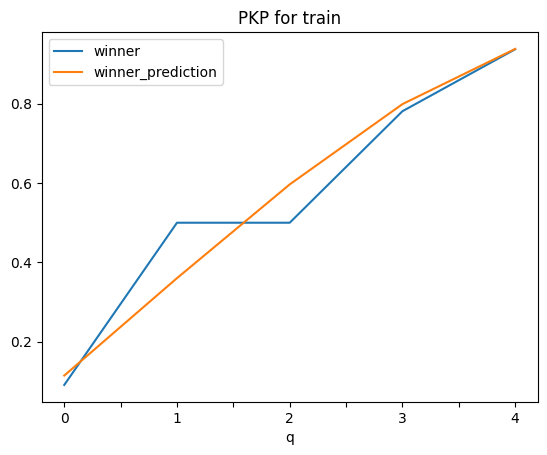

AUC ROC test: 0.7808


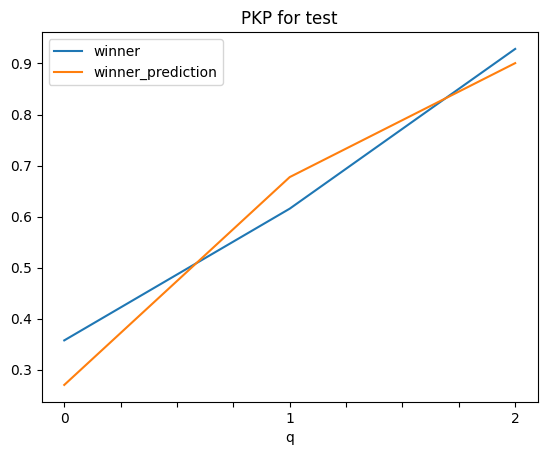

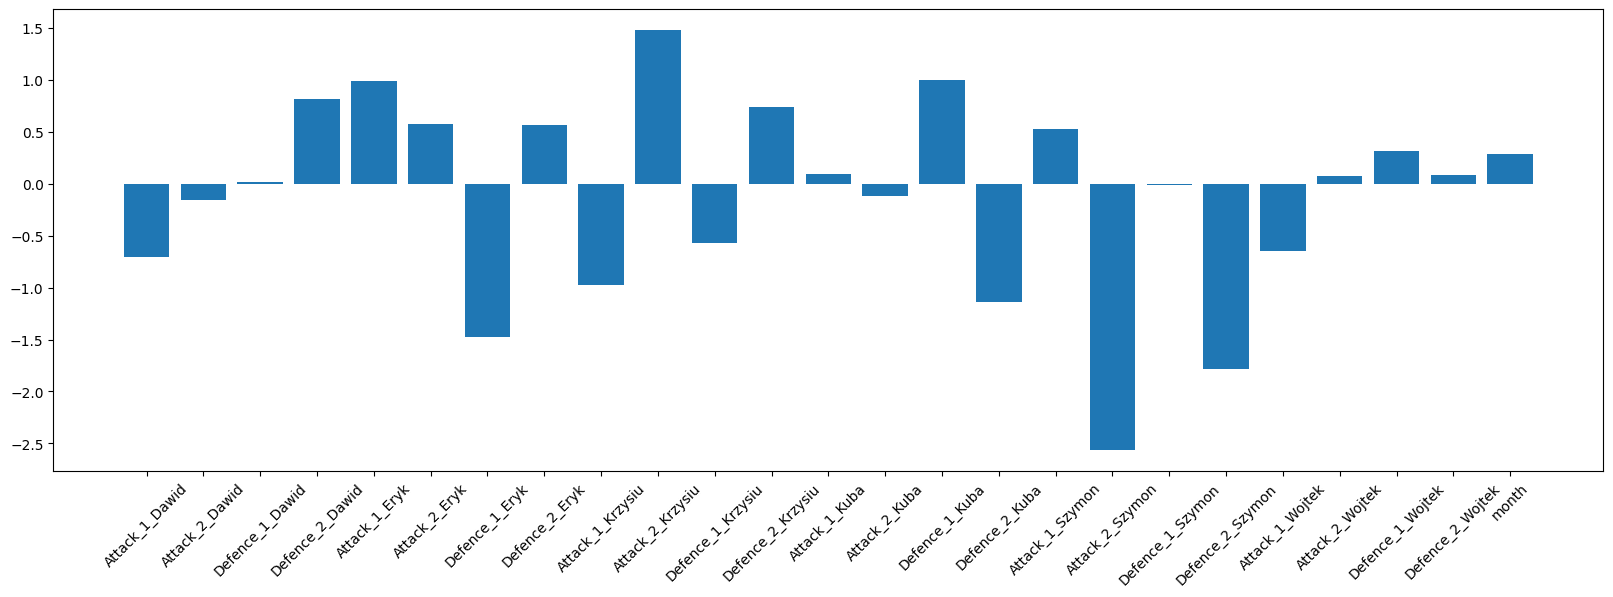

In [17]:
model_class.fit(train[desc], train["winner"])
test["winner_prediction"] = model_class.predict_proba(test[desc])[:, 1]
train["winner_prediction"] = model_class.predict_proba(train[desc])[:, 1]
metrics_class(train, "train", "winner", "winner_prediction")
metrics_class(test, "test", "winner", "winner_prediction", 3)
print_log_reg_coefs(train, model_class, desc)

In [43]:
model_reg = LinearRegression(fit_intercept=False)

R2 for train: 0.4439


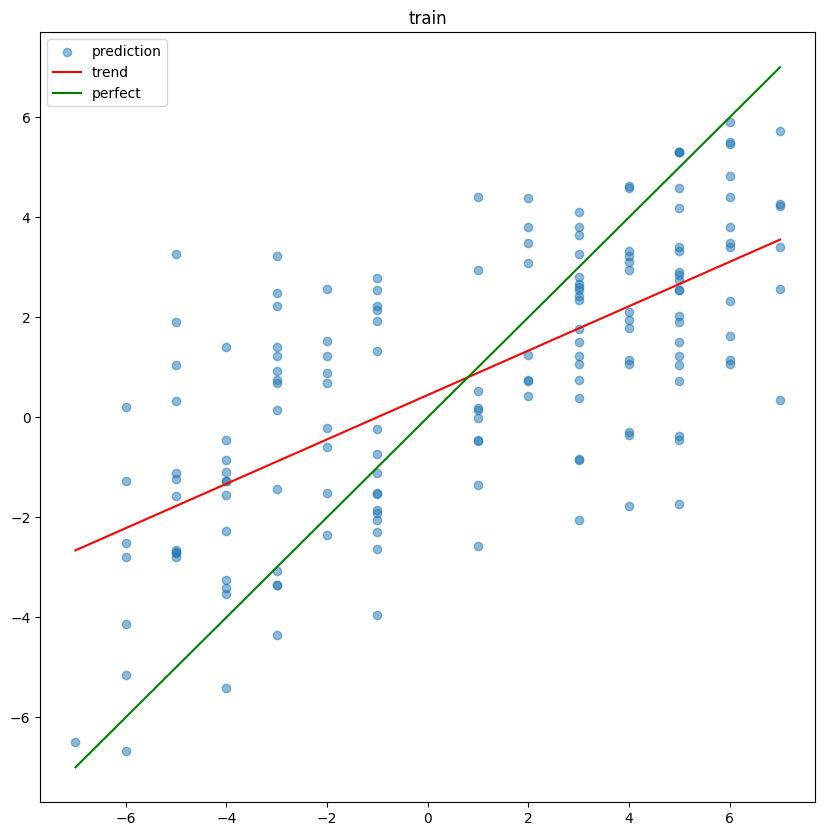

R2 for test: 0.2651


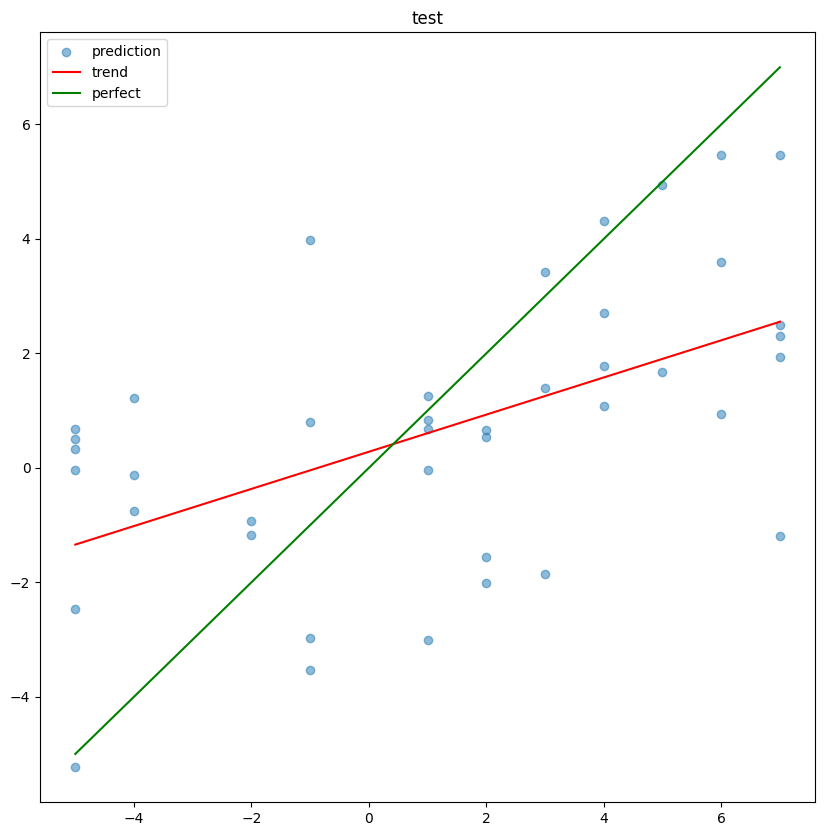

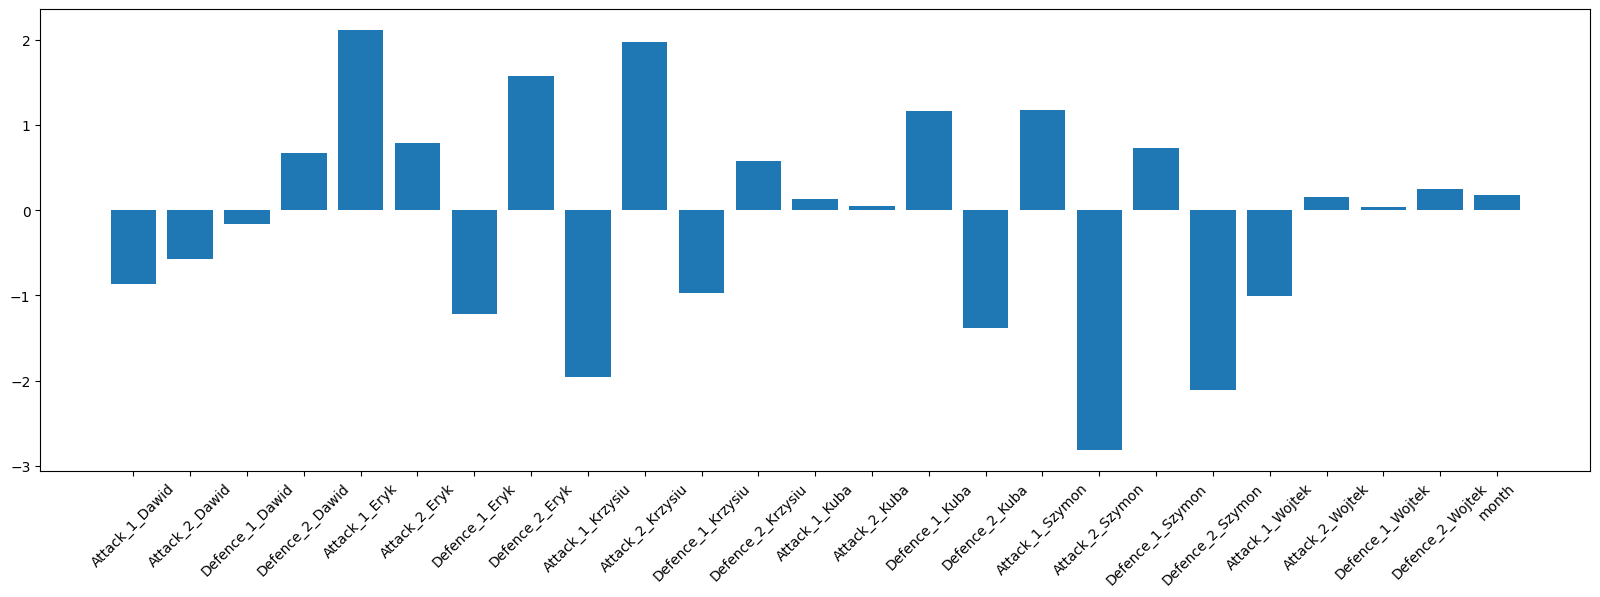

In [44]:
model_reg.fit(train[desc], train["result"])
test["result_prediction"] = model_reg.predict(test[desc])
train["result_prediction"] = model_reg.predict(train[desc])
metrics_reg(train, "train", "result", "result_prediction")
metrics_reg(test, "test", "result", "result_prediction")
print_lin_reg_coefs(train, model_reg, desc)
